In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import pandas as pd

import dask.dataframe as dd

from pathlib import Path

from forceClass import Forces
from forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t


from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return -a*xData**b + c

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

def fit_data_poly(xData, yData, rank):
        tmp_poly = np.polyfit(xData, yData, rank)
        return np.poly1d(tmp_poly)

In [3]:
# Initial Parameters

# location of the data
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/Carangiform Data'

paths = pio.get_files(data_location, '*.csv')

In [4]:
data = []
case_dict = dict()

for path in paths:
    data.append(dd.read_csv(path, delimiter=',', skiprows=7))
    
    index = 0
    with open(path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            elif line.split()[0] == '#':
                if index == 0:
                    case = line.split()[1]
                    case_dict[case] = {}
                    index += 1
                elif index == 1:
                    case_dict[case]['amplitude'] = float(line.split()[2])
                    index += 1
                elif index == 2:
                    case_dict[case]['lambda'] = float(line.split()[2])
                    index += 1
                elif index == 3:
                    case_dict[case]['k'] = float(line.split()[4])
                    index += 1
                elif index == 4:
                    case_dict[case]['U'] = float(line.split()[3])
                    index += 1
            else:
                pass
    
    f.close()

In [10]:
force_dict = dict()

force_dict['Ft_fit'] = []
force_dict['Fx_fit'] = []
force_dict['power_fit'] = []
force_dict['zero_St'] = []


for frame in data:
    St = frame['St'].unique().compute()
    Re = frame['Re'].unique().compute()
    Ft = frame['Ft'].compute()-1
    Fx = frame['total_x'].compute()
    power = frame['Power'].compute()

    force_dict['St'] = St
    force_dict['Re'] = Re

    Re_index = 0
    for i in np.arange(0, St.shape[0]*Re.shape[0],St.shape[0]):
        Ft_fit = fit_data_poly(St, Ft[i:i+St.shape[0]], 2)
        zero_Ft_fit = fit_data_poly(Ft[i:i+St.shape[0]], St, 2)
        Fx_fit = fit_data_poly(St, Fx[i:i+St.shape[0]], 2)
        power_fit = fit_data_poly(St, Fx[i:i+St.shape[0]], 2)

        force_dict['Ft_fit'].append(Ft_fit)
        force_dict['Fx_fit'].append(Fx_fit)
        force_dict['power_fit'].append(power_fit)
        force_dict['zero_St'].append(zero_Ft_fit(0))

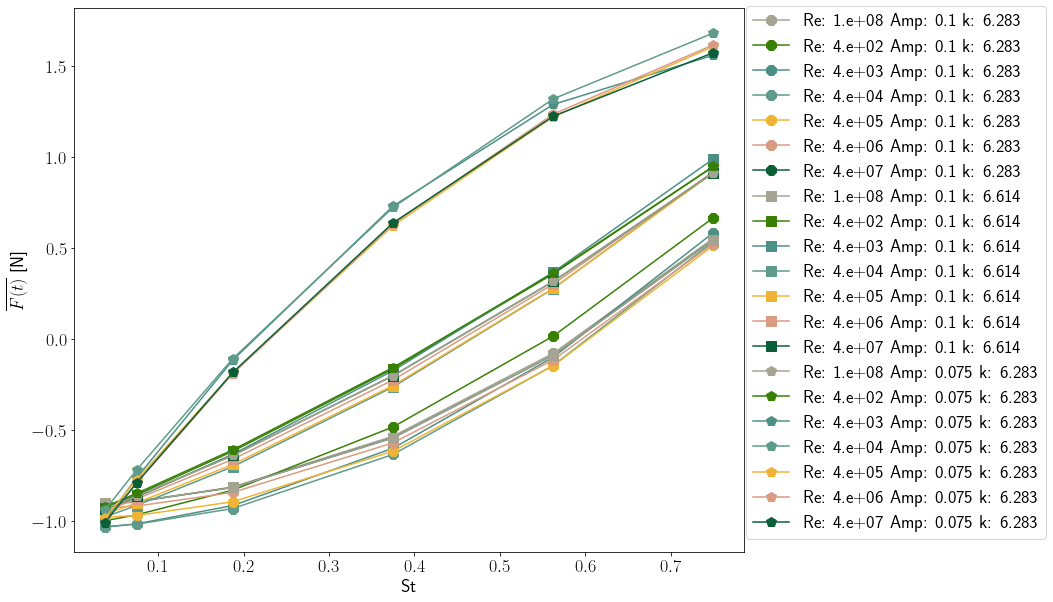

In [11]:
plt.rcParams.update({"font.size":18, 'text.usetex':True})

markers = [marker for marker in Line2D.markers]
line_color = [name for name in mcd.XKCD_COLORS]

fig1, ax1 = plt.subplots(figsize=(12,10))

for i, case in enumerate(case_dict):
    for j, Re in enumerate(force_dict['Re']):
        ax1.plot(force_dict['St'], force_dict['Ft_fit'][j + (i*force_dict['St'].shape[0])](force_dict['St']), markers[i+11] + '-', 
                color=line_color[j+11], ms=10, label='Re: ' + np.format_float_scientific(Re) + ' Amp: ' + str(case_dict[case]['amplitude']) + 
                ' k: ' + str(np.round(case_dict[case]['k'], 3)))

ax1.set_xlabel('St')
ax1.set_ylabel('$\overline{F(t)}$ [N]')
ax1.legend(bbox_to_anchor=(0.99, 1.02))

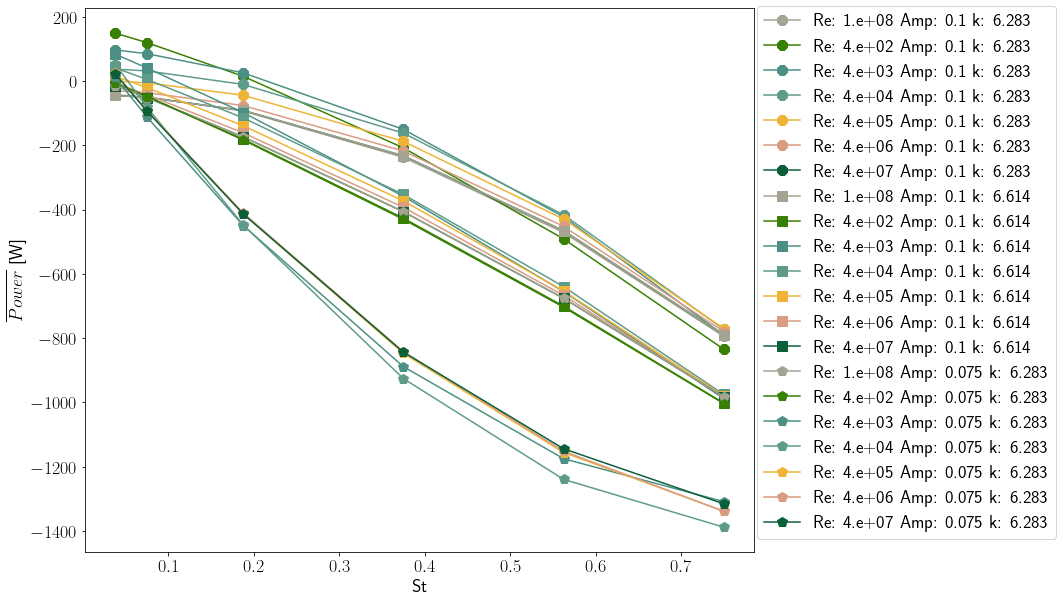

In [12]:
fig2, ax2 = plt.subplots(figsize=(12,10))

for i, case in enumerate(case_dict):
    for j, Re in enumerate(force_dict['Re']):
        ax2.plot(force_dict['St'], force_dict['power_fit'][j + (i*force_dict['St'].shape[0])](force_dict['St']), markers[i+11] + '-', 
                color=line_color[j+11], ms=10, label='Re: ' + np.format_float_scientific(Re) + ' Amp: ' + str(case_dict[case]['amplitude']) + 
                ' k: ' + str(np.round(case_dict[case]['k'], 3)))

ax2.set_xlabel('St')
ax2.set_ylabel('$\overline{Power}$ [W]')
ax2.legend(bbox_to_anchor=(0.99, 1.02))

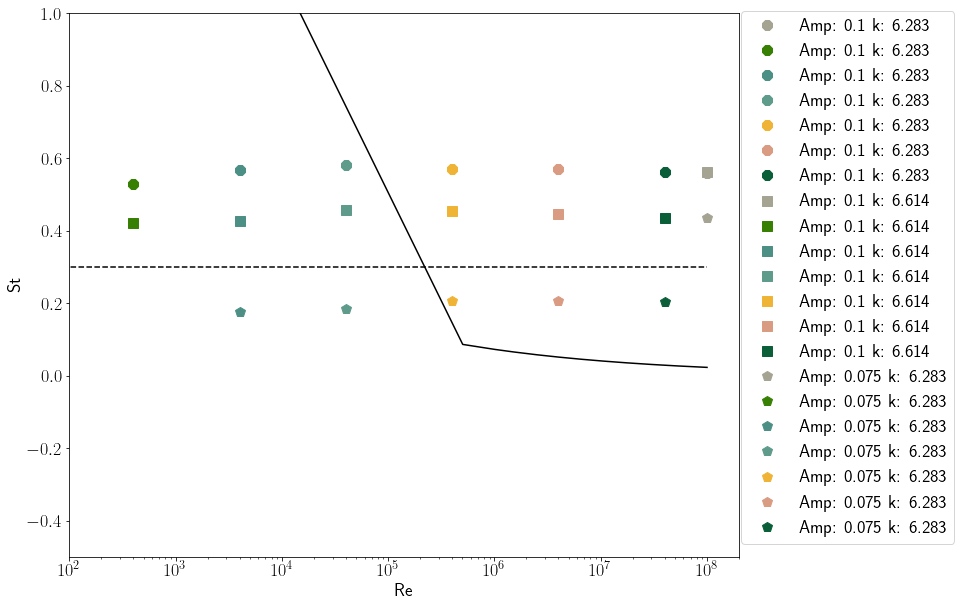

In [17]:
Re_plot = np.linspace(0.1, 1e8, 200)
St_plot_low = 2.3*Re_plot**(-1/4)

fig3, ax3 = plt.subplots(figsize=(12,10))

for i, case in enumerate(case_dict):
    for j, Re in enumerate(force_dict['Re']):
        ax3.plot(Re, force_dict['zero_St'][j + (i*force_dict['St'].shape[0])], markers[i+11], 
                color=line_color[j+11], ms=10, label='Amp: ' + str(case_dict[case]['amplitude']) + ' k: ' + str(np.round(case_dict[case]['k'], 3)))

ax3.plot(Re_plot, St_plot_low, 'k')
ax3.plot([0.1, 1e8], [0.3, 0.3], 'k--')

ax3.set_xscale('log')
ax3.set_xlabel('Re')
ax3.set_ylabel('St')
ax3.set_ylim([-0.5, 1.0])
ax3.set_xlim([1e2, 2e8])
ax3.legend(bbox_to_anchor=(0.99, 1.02))

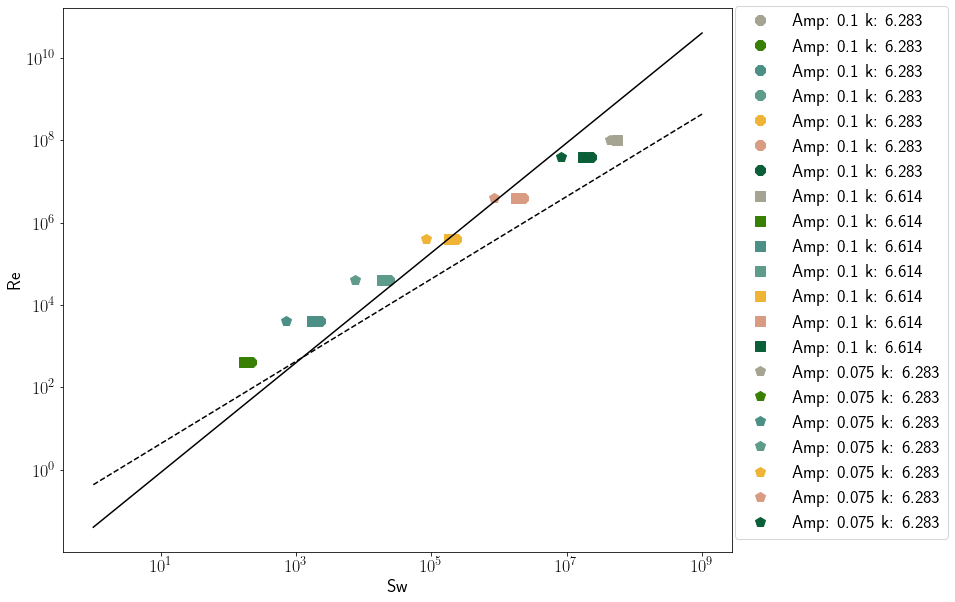

In [15]:
Sw_plot = np.linspace(1, 1e9, 200)
Re_low = 0.04*Sw_plot**(4/3)
Re_high = 0.43*Sw_plot 

fig4, ax4 = plt.subplots(figsize=(12,10))

for i, case in enumerate(case_dict):
    for j, Re in enumerate(force_dict['Re']):
        Sw = force_dict['zero_St'][j + (i*force_dict['St'].shape[0])] * Re
        ax4.plot(Sw, Re,    markers[i+11], color=line_color[j+11], ms=10, label='Amp: ' + str(case_dict[case]['amplitude']) + 
        ' k: ' + str(np.round(case_dict[case]['k'], 3)))

ax4.plot(Sw_plot, Re_low, 'k')
ax4.plot(Sw_plot, Re_high, 'k--')

ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('Sw')
ax4.set_ylabel('Re')
ax4.legend(bbox_to_anchor=(0.99, 1.02))
#fig6.savefig(Path(figure_location).joinpath('Sw_Re.png'))